In [27]:
"""
Title: Full Preprocessing, Feature Engineering, and Modeling Pipeline for Hospital Bed Utilization

Description:
This script performs the complete data pipeline for analyzing and modeling hospital bed utilization rates
using social determinants of health (SDOH) and geographic access features. The workflow includes:

1. Data Loading and Initial Exploration
2. Preprocessing and Filtering (e.g., region/state exclusions, missing data handling)
3. Feature Engineering:
   - One-hot encoding of Region
   - Target encoding of State
   - Binary encoding and KNN imputation for Is_Metro_Micro
4. Data Standardization
5. Train-Test Splitting using calculated ratio
6. Export of final datasets:
   - Full dataset with preserved missing targets
   - Modeling-only dataset (no missing targets)
7. Normality Assessment (Shapiro-Wilk, Q-Q Plot, KDE)
8. Box-Cox transformation for target normalization (optional step)
9. Predictive Modeling:
   - Ridge and Lasso Regression (pre- and post-transformation)
   - Residual analysis and diagnostic testing (Shapiro-Wilk, Breusch-Pagan)
10. Export of modeling-ready files and visualizations

Inputs:
- 'MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv': Raw merged dataset with renamed variables

Outputs:
- 'final_full_dataset_with_preserved_missing_targets.xlsx': Full dataset with encoded, imputed values
- 'modeling_dataset_only.xlsx': Cleaned and ready dataset for modeling without missing targets

Note:
- Target variable: 'Bed_util_ratio'
- Special handling applied to: 'Is_Metro_Micro', 'State', and 'Region'
- Box-Cox applied to transform target variable when required
- Residual diagnostics included to evaluate assumptions of regression models
"""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Data Loading and Initial Exploration

In [28]:
df = pd.read_csv('MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountyFIPS,3239.0,31504.662550,16462.990939,1001.000000,19032.000000,30033.000000,46126.000000,7.803000e+04
Pct_renter_occupied,3234.0,26.781928,9.633306,0.000000,21.333333,26.000000,31.798276,8.200000e+01
Distance_to_medsurge_icu,3234.0,12.573051,17.665270,0.000000,4.666666,7.300000,16.500000,4.870000e+02
Pct_renter_cost_50pct_plus,3234.0,18.632206,7.791009,0.000000,14.283193,18.836021,23.285714,7.500000e+01
Pct_renter_cost_30pct_plus,3234.0,39.682482,12.036717,0.000000,34.000000,41.000000,46.761029,1.000000e+02
Total_population_poverty,3234.0,98504.677798,322472.553341,0.000000,9612.250000,23553.000000,63324.000000,9.884138e+06
Pct_owner_cost_30plus,3234.0,17.706173,5.730589,0.000000,14.833333,17.500000,20.698997,4.275000e+01
Population_density,3234.0,891.208574,2798.157565,0.000000,41.525000,209.100000,907.020161,9.038623e+04
Land_area_sqmi,3234.0,289.385427,1296.982616,0.000000,27.857143,72.000000,173.317307,3.639325e+04
Median_hh_income,3234.0,53803.784787,17732.176889,0.000000,44620.500000,52881.500000,61834.750000,1.485230e+05


In [31]:
df.isna().sum()

,0
CountyFIPS,0
State,0
County,5
Region,96
Pct_renter_occupied,5
Distance_to_medsurge_icu,5
Pct_renter_cost_50pct_plus,5
Pct_renter_cost_30pct_plus,5
Total_population_poverty,5
Pct_owner_cost_30plus,5


In [32]:
# Display structure and summary
print(df.shape)
print(df.dtypes.value_counts())

(3239, 24)
float64    20
object      3
int64       1
Name: count, dtype: int64


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

# Preprocessing, Encoding, Imputation

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop


# Filter
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

# Now drop these columns
df_cleaned = df_cleaned.drop(columns=["State", "Land_area_sqmi"], errors="ignore")
# ----------------------------------------------------------



# Drop rows with missing predictor values (except for Is_Metro_Micro and Bed_util_ratio)
predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# Split into: with-target (for modeling) vs. missing-target (for our preservation)
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# Train-test split
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]

split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# Encoding
# Binary encode Is_Metro_Micro
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})


# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County"], errors="ignore")
X_test = X_test.drop(columns=["CountyFIPS", "County"], errors="ignore")


# Scaling + Imputation for Is_Metro_Micro only
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


# KNN Impute Is_Metro_Micro
knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# -----------------
# Above
# Reattach target
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

# Combine for modeling dataset
df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# Append back missing-target rows for full dataset view
# We just encode + scale them similarly (skip splitting)
df_missing_target_encoded = df_missing_target.copy()

# Binary encode Is_Metro_Micro
df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})


# One-hot encode Region and align
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)

# Align to X_train columns
df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

# Standardize numeric
df_missing_scaled = df_missing_target_encoded.copy()

# Ensure we only transform the same columns used during fit
# reorder + subset
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)


# Impute Is_Metro_Micro
df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# Final full dataset
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# Export if needed
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

# Export Modeling-Only Dataset (no missing Bed_util_ratio)
df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 22)
Rows with missing Bed_util_ratio preserved separately: (751, 22)

Calculated train/test split: 0.78/0.22

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.425206                 -0.471017                    1.383843   
1            -0.699455                 -0.248219                    0.014196   
2             1.178700                 -0.127155                    0.188555   
3            -0.479857                  1.178608                    1.290080   
4            -0.534053                 -0.014738                    0.638884   

   Pct_renter_cost_30pct_plus  Total_population_poverty  \
0                    0.232615                 -0.184447   
1                    0.302099                  0.265340   
2                    0.574516                 -0.277534   
3                    0.956495         

In [35]:
print([col for col in df_cleaned.columns if "Land" in col])


[]


In [36]:
X_train_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0


In [37]:
X_test_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0


In [38]:
len(X_train_scaled), len(X_test_scaled)

(1864, 527)

## Evaluation

### Histogram of Bed_util_ratio - Train vs Test (No Imputation)

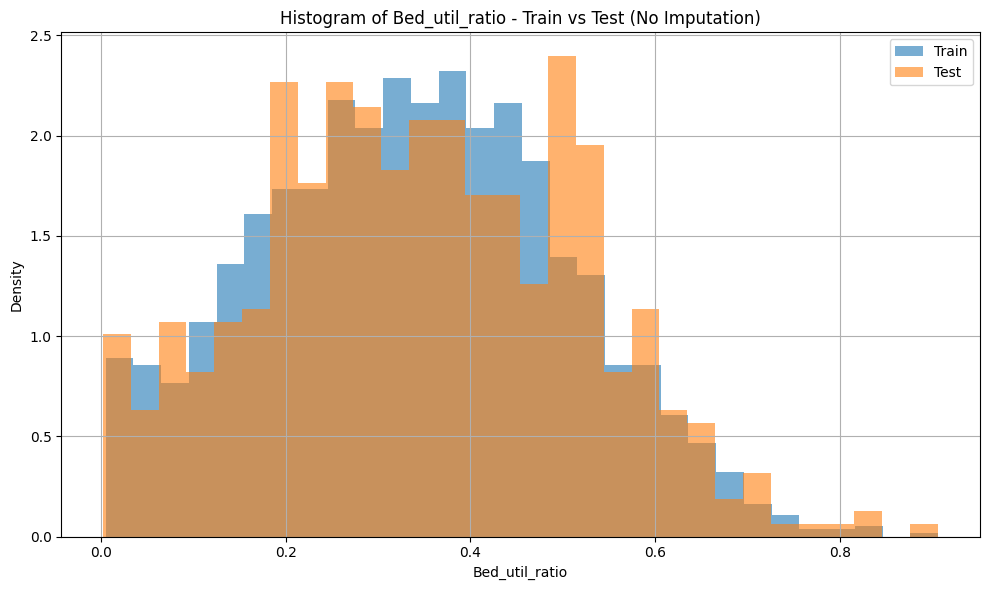

In [39]:
# === Histogram of Bed_util_ratio - Train vs Test (No Imputation) ===
plt.figure(figsize=(10, 6))
plt.hist(train_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Train", density=True)
plt.hist(test_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Test", density=True)
plt.title("Histogram of Bed_util_ratio - Train vs Test (No Imputation)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### BarPlot - Imputation Comparison for Is_Metro_Micro

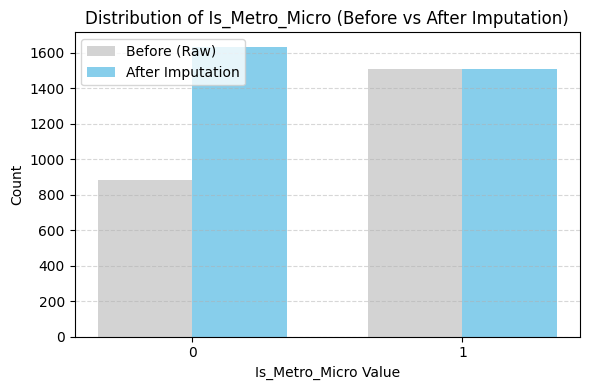

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Before imputation: include NaNs
before = df_cleaned["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan}).value_counts(dropna=False)
before.index = before.index.astype("object")  # so NaN label is retained

# After imputation: should be only 0 and 1
after = df_final_full["Is_Metro_Micro"].value_counts()

# Align both to 0 and 1 only (for bar chart)
x_labels = [0, 1]
before_aligned = [before.get(0, 0), before.get(1, 0)]
after_aligned = [after.get(0, 0), after.get(1, 0)]

# Plot
bar_width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before_aligned, width=bar_width, label="Before (Raw)", color="lightgray")
plt.bar(x + bar_width/2, after_aligned, width=bar_width, label="After Imputation", color="skyblue")

plt.xticks(ticks=x, labels=["0", "1"])
plt.xlabel("Is_Metro_Micro Value")
plt.ylabel("Count")
plt.title("Distribution of Is_Metro_Micro (Before vs After Imputation)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Shapiro-Wilk W Statistic for Bed_util_ratio

In [41]:
from scipy.stats import shapiro

# Run only on non-null values
target_values = df_final_full["Bed_util_ratio"].dropna()

# Perform Shapiro-Wilk test
stat, p = shapiro(target_values)

print("Shapiro-Wilk W Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")


Shapiro-Wilk W Statistic: 0.9919237932068726
p-value: 2.821064526072581e-10
Target likely not normally distributed (reject H0)


In [42]:
Shapiro_Result = """We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. \nThe resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. \nThis insight may inform downstream modeling choices (e.g., transformation before regularized regression). \nSince our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), \nwe retained the raw distribution of the target for now."""
print(Shapiro_Result)

We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. 
The resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. 
This insight may inform downstream modeling choices (e.g., transformation before regularized regression). 
Since our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), 
we retained the raw distribution of the target for now.


### Distribution of Bed_Util_Ratio w/ KDE

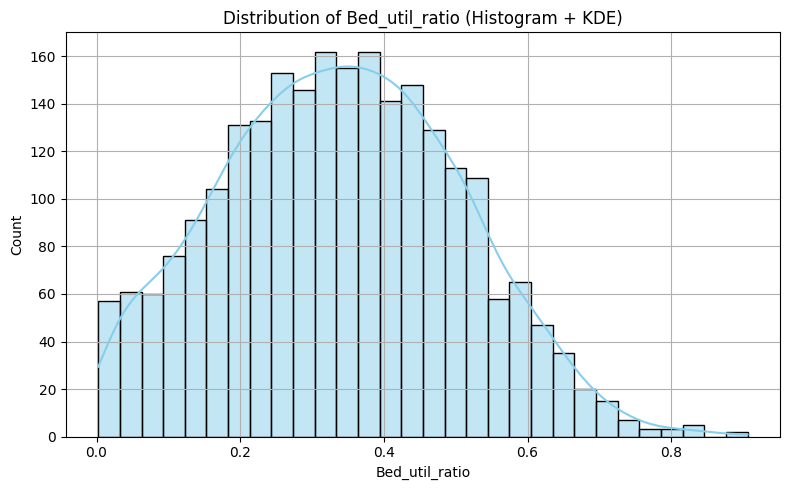

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(bed_util_values, kde=True, bins=30, color="skyblue")
plt.title("Distribution of Bed_util_ratio (Histogram + KDE)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### Q-Q Plot for Normality Check

<Figure size 600x600 with 0 Axes>

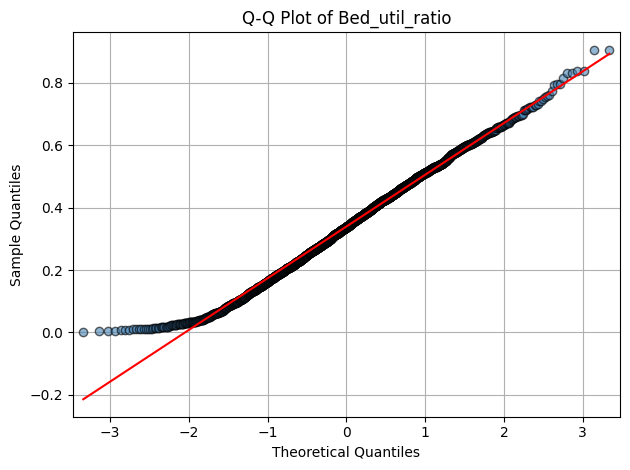

In [44]:
import statsmodels.api as sm
import scipy.stats as stats

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# QQ plot
plt.figure(figsize=(6, 6))
sm.qqplot(bed_util_values, line="s", markerfacecolor='steelblue', markeredgecolor='black', alpha=0.6)
plt.title("Q-Q Plot of Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


# PCA

## PCA Setup with Box-Cox Transformation

Box-Cox Lambda: 0.7989


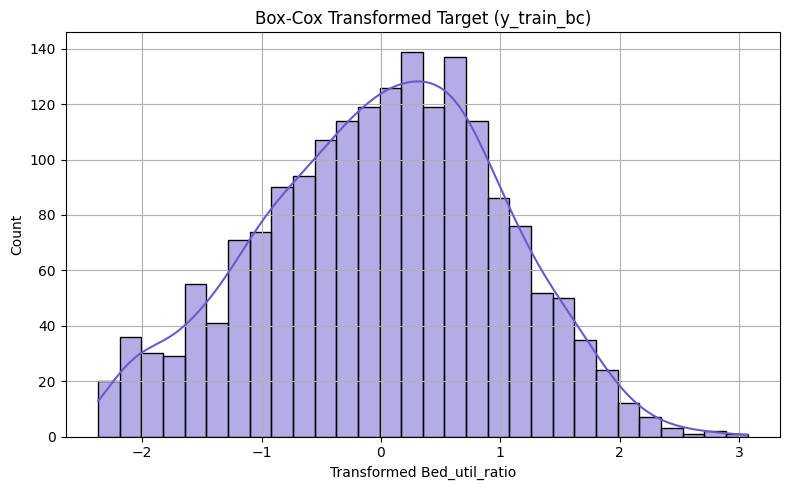

Shapiro-Wilk Test for Normality of Transformed Target:
W = 0.9930, p = 0.0000
Transformed target likely not normal.


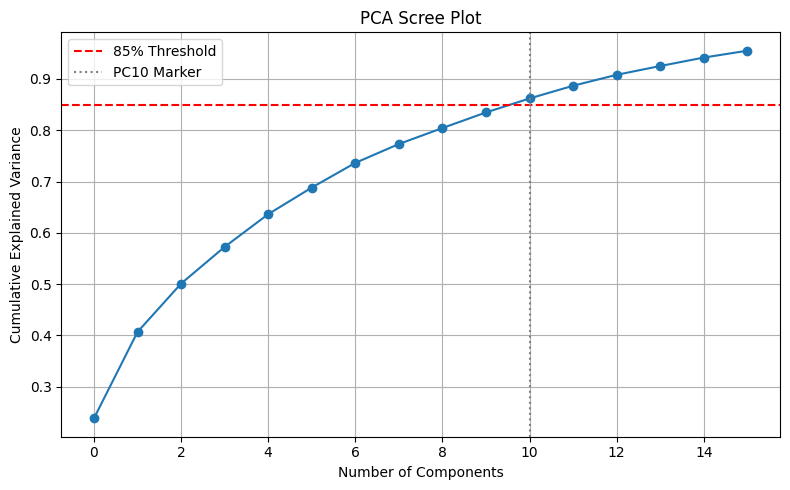

,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.238408,0.238408
1,PC2,0.168370,0.406778
2,PC3,0.094237,0.501014
3,PC4,0.071579,0.572594
4,PC5,0.063747,0.636341
5,PC6,0.051870,0.688211
6,PC7,0.048140,0.736351
7,PC8,0.036766,0.773118
8,PC9,0.031167,0.804284
9,PC10,0.030396,0.834681


Original shape (X_train_scaled): (1864, 21)
Reduced shape after PCA (train): (1864, 16)
Reduced shape after PCA (test): (527, 16)


In [45]:
"""
This cell continues from the preprocessing pipeline and assumes the following
variables are already defined:
- X_train_scaled, X_test_scaled: scaled feature sets (with no missing values)
- y_train, y_test: untransformed target values (may include small or non-positive values)

This step performs:
- Box-Cox transformation on the target (Bed_util_ratio) to correct skewness and approximate normality
    - Applies safe shifting for Box-Cox if any values are ≤ 0
    - Includes diagnostic checks: histogram and Shapiro-Wilk test
- Principal Component Analysis (PCA) on the scaled features to reduce dimensionality
    - Retains enough components to explain ≥95% of variance
    - Visualizes cumulative explained variance via a scree plot

Final outputs:
- Transformed target: y_train_bc, y_test_bc
- Reduced feature sets: X_train_pca, X_test_pca
- Diagnostic outputs for lambda, distribution, normality, and variance retention
"""


# --- Box-Cox Transformation + PCA Setup ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.special import inv_boxcox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Shift the target if needed (Box-Cox requires strictly positive values)
if (y_train <= 0).any():
    shift_amount = abs(y_train.min()) + 0.01
    y_train_shifted = y_train + shift_amount
    y_test_shifted = y_test + shift_amount
else:
    shift_amount = 0
    y_train_shifted = y_train
    y_test_shifted = y_test

# Apply Box-Cox
pt = PowerTransformer(method='box-cox')
y_train_bc = pt.fit_transform(y_train_shifted.values.reshape(-1, 1)).flatten()
y_test_bc = pt.transform(y_test_shifted.values.reshape(-1, 1)).flatten()
lambda_bc = pt.lambdas_[0]

# ----------------------
# Box-Cox Diagnostic Output

print(f"Box-Cox Lambda: {lambda_bc:.4f}")

# Histogram of Box-Cox Transformed Target
plt.figure(figsize=(8, 5))
sns.histplot(y_train_bc, bins=30, kde=True, color='slateblue')
plt.title("Box-Cox Transformed Target (y_train_bc)")
plt.xlabel("Transformed Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

stat_bc, p_bc = shapiro(y_train_bc)
print(f"Shapiro-Wilk Test for Normality of Transformed Target:")
print(f"W = {stat_bc:.4f}, p = {p_bc:.4f}")
if p_bc > 0.05:
    print("Transformed target appears approximately normal.")
else:
    print("Transformed target likely not normal.")

# ----------------------
# ------------PCA----------------

# PCA on scaled features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.axhline(y=0.85, color='r', linestyle='--', label='85% Threshold')
plt.axvline(x=10, color='grey', linestyle='dotted', label='PC10 Marker')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# View explained variance (optional)
explained_variance = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": np.cumsum(pca.explained_variance_ratio_)
})
display(explained_variance.head(10))

# --- Final Output ---
# Inspect original shape ---
print("Original shape (X_train_scaled):", X_train_scaled.shape)
print("Reduced shape after PCA (train):", X_train_pca.shape)
print("Reduced shape after PCA (test):", X_test_pca.shape)



## SVM Regression + Evaluation (PCA & SVM Combined w/ CV)

Cross-Validated R² (train): 0.2989 ± 0.0262
Test RMSE (Box-Cox): 0.8684
Test MAE (Box-Cox):  0.6691
Test R² (Box-Cox):   0.3143

Shapiro-Wilk: W = 0.9933, p = 0.0195
Not Normal


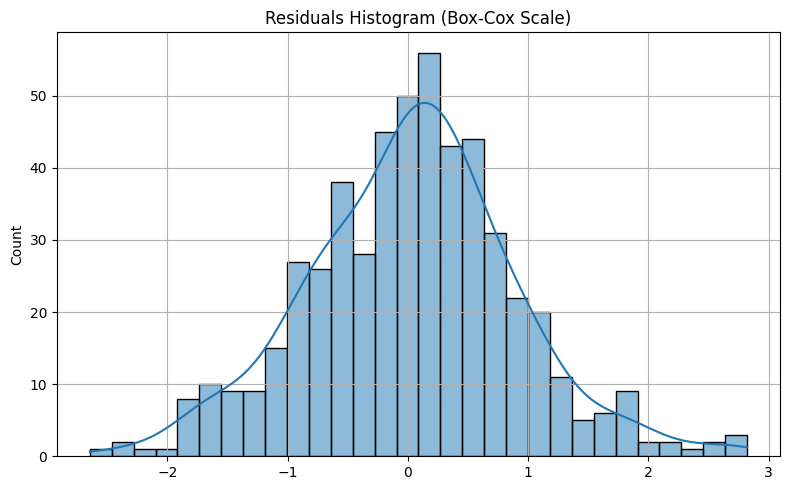

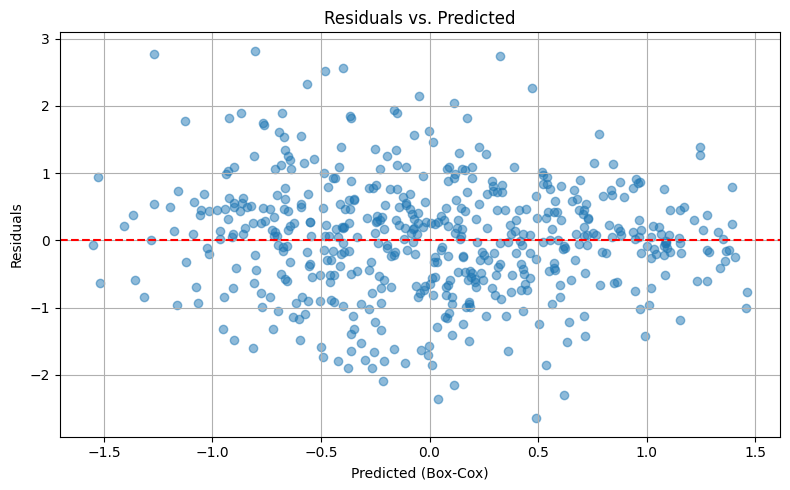


Final RMSE (Original Scale): 0.8051
Dropped 10 NaN predictions from inverse Box-Cox.



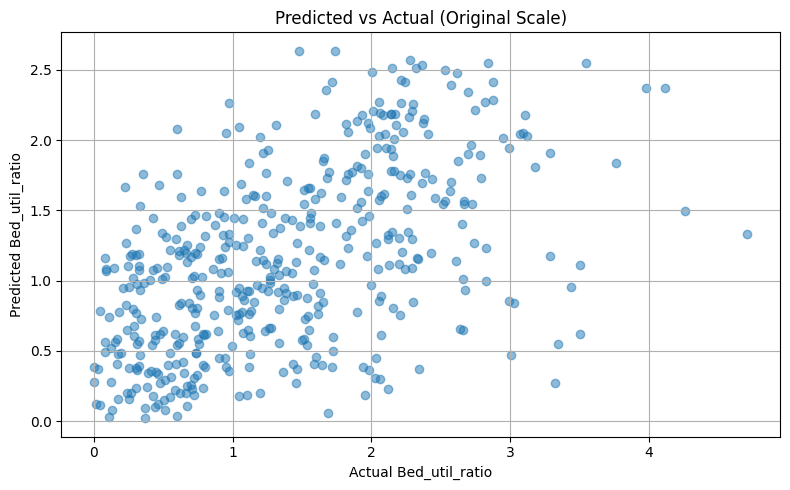

In [46]:
"""
This cell trains and evaluates a Support Vector Regression (SVR) model using
PCA-reduced features and a Box-Cox transformed target.

Workflow Context:
- This step uses PCA-transformed feature sets ('X_train_pca', 'X_test_pca'),
which reduced the original 23 features to 17 components explaining ≥95% of the variance.
- The target variable ('Bed_util_ratio') was transformed using Box-Cox to correct skewness
and approximate normality.
- 'y_train_bc' and 'y_test_bc' are the Box-Cox transformed versions of the target.

What this cell performs:
Fits an SVR model (RBF kernel) **on PCA-reduced input features**
-  Uses 5-fold cross-validation to estimate model R² performance on training data
-  Makes predictions on the Box-Cox-transformed test set ('y_test_bc')
-  Computes key evaluation metrics (RMSE, MAE, R²) **on Box-Cox scale**
-  Performs residual diagnostics, including:
    - Shapiro-Wilk test for residual normality
    - Histogram and residual plots
-  Applies **inverse Box-Cox transformation** to return predictions to original scale
    - Applies inverse Box-Cox transformation to return predictions and test targets to original scale
    - Handles potential NaNs from numerical issues in predictions by filtering invalid values
    - Does not reintroduce original missing values —
    transformations are applied only to the already-clean test set
-  Computes final RMSE in original units and visualizes actual vs. predicted values

Note:
- PCA and SVR together make this a nonlinear regression pipeline with dimensionality reduction.
- The Box-Cox inverse transformation includes safe handling of small/zero values and drops invalid predictions (e.g., due to numerical issues).
"""

# --- SVM Regression + Evaluation ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro

# Fit SVM model
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_train_pca, y_train_bc, cv=cv, scoring='r2')

svm.fit(X_train_pca, y_train_bc)
y_pred_bc = svm.predict(X_test_pca)

# Evaluate on Box-Cox Scale
rmse = np.sqrt(mean_squared_error(y_test_bc, y_pred_bc))
mae = mean_absolute_error(y_test_bc, y_pred_bc)
r2 = r2_score(y_test_bc, y_pred_bc)
print(f"Cross-Validated R² (train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test RMSE (Box-Cox): {rmse:.4f}")
print(f"Test MAE (Box-Cox):  {mae:.4f}")
print(f"Test R² (Box-Cox):   {r2:.4f}")

# Residuals
residuals = y_test_bc - y_pred_bc
stat, p_val = shapiro(residuals)
print(f"\nShapiro-Wilk: W = {stat:.4f}, p = {p_val:.4f}")
print("Likely Normal" if p_val > 0.05 else "Not Normal")

# Residual Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Histogram (Box-Cox Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_bc, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform to Original Scale
y_pred_orig = inv_boxcox(y_pred_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

# Combine both masks to ensure no NaNs in either y_pred or y_test
valid_mask = ~np.isnan(y_pred_orig) & ~np.isnan(y_test_orig)

rmse_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask], y_pred_orig[valid_mask]))
print(f"\nFinal RMSE (Original Scale): {rmse_orig:.4f}")
print(f"Dropped {np.isnan(y_pred_orig).sum()} NaN predictions from inverse Box-Cox.\n")

# Predicted vs Actual Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig[valid_mask], y_pred_orig[valid_mask], alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
print("NaNs in y_test_orig:", np.isnan(y_test_orig).sum())
print("NaNs in y_pred_orig:", np.isnan(y_pred_orig).sum())


NaNs in y_test_orig: 66
NaNs in y_pred_orig: 10


## PCA Plots with Loadings

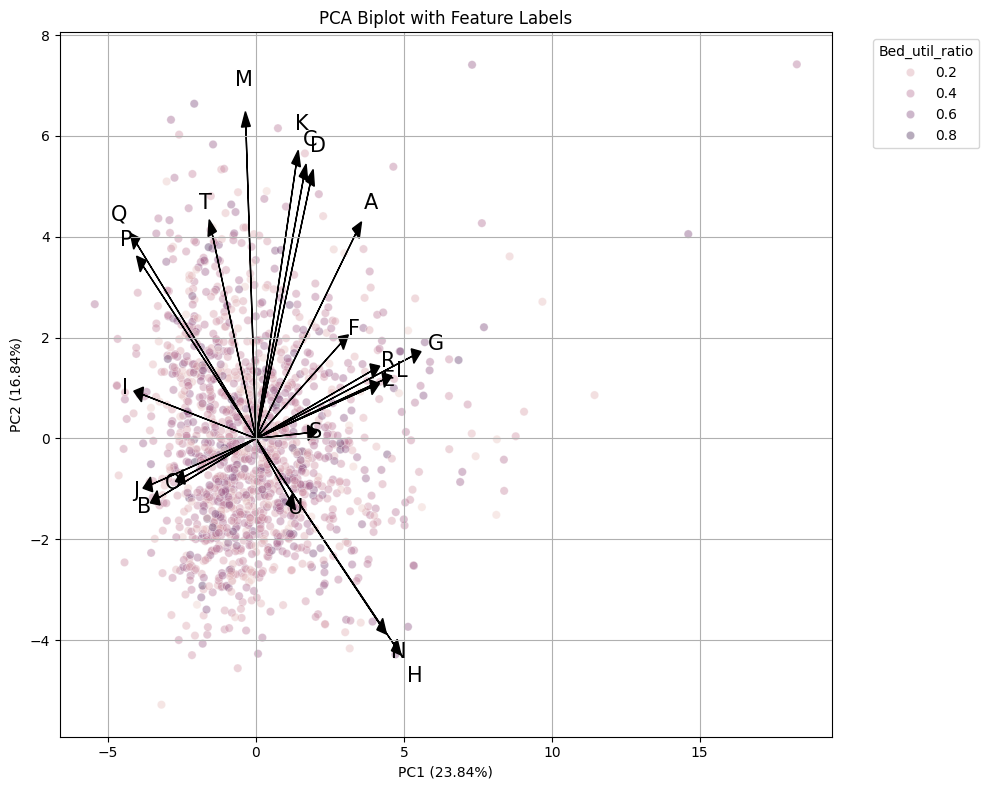

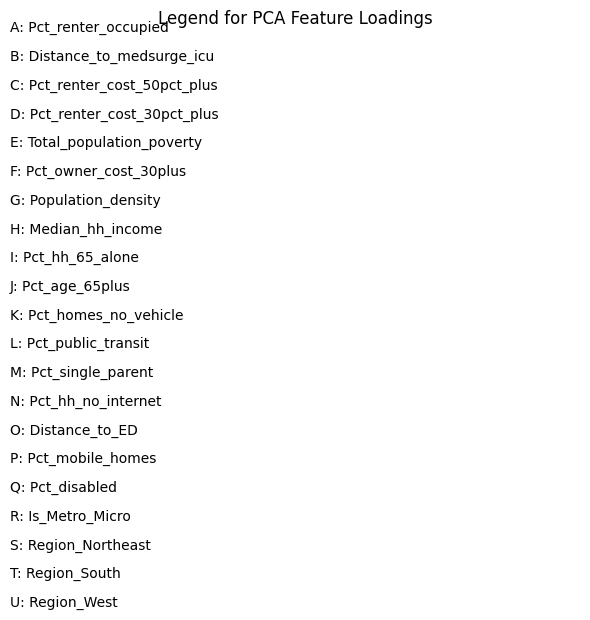

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import string


#our variables
feature_names = [
    'Pct_renter_occupied', 'Distance_to_medsurge_icu', 'Pct_renter_cost_50pct_plus',
    'Pct_renter_cost_30pct_plus', 'Total_population_poverty', 'Pct_owner_cost_30plus',
    'Population_density', 'Median_hh_income', 'Pct_hh_65_alone', 'Pct_age_65plus',
    'Pct_homes_no_vehicle', 'Pct_public_transit', 'Pct_single_parent', 'Pct_hh_no_internet',
    'Distance_to_ED', 'Pct_mobile_homes', 'Pct_disabled', 'Is_Metro_Micro',
    'Region_Northeast', 'Region_South', 'Region_West'
]

# Assign variable to a letter
import string
feature_labels = list(string.ascii_uppercase[:len(feature_names)])
label_map = dict(zip(feature_names, feature_labels))

# Define the loading_plot function
def loading_plot(coeff, labels, scale=6, colors=None, visible=None, ax=plt, arrow_size=0.05, font_size=12):
    for i, label in enumerate(labels):
        if visible is None or visible[i]:
            ax.arrow(0, 0,
                     coeff[i, 0] * scale,
                     coeff[i, 1] * scale,
                     head_width=arrow_size * scale,
                     head_length=arrow_size * scale,
                     color="#000" if colors is None else colors[i])
            ax.text(coeff[i, 0] * 1.15 * scale,
                    coeff[i, 1] * 1.15 * scale,
                    label_map[label],  # Use the assigned letter
                    color="#000" if colors is None else colors[i],
                    ha="center", va="center", fontsize=font_size)

# Create PCA DataFrame for plotting using df_final_full
pca_df = pd.DataFrame(X_train_pca[:, :2], columns=["PC1", "PC2"])

# Loadings for the first two components
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=["PC1", "PC2"],
    index=feature_names
)

# Plot PCA biplot with feature loadings
plt.figure(figsize=(10, 8))

sns.scatterplot(x="PC1", y="PC2", data=pca_df, hue=df_final_full["Bed_util_ratio"], alpha=0.4)
loading_plot(loadings.values, labels=loadings.index, scale=15, arrow_size=0.02, font_size=15)

# Add axis labels and title
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot with Feature Labels")

# Add a legend in the top right corner for Bed_util_ratio
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title='Bed_util_ratio')

# Show grid and finalize plot layout
plt.grid(True)
plt.tight_layout()
plt.show()

# Create legend
legend_labels = [f"{label_map[name]}: {name}" for name in feature_names]

plt.figure(figsize=(6, len(legend_labels) * 0.3))
plt.axis('off')
for i, txt in enumerate(legend_labels):
    plt.text(0, 1 - i * 0.05, txt, fontsize=10)
plt.title("Legend for PCA Feature Loadings", fontsize=12)
plt.tight_layout()
plt.show()

## View - Top Predicters for PC1 only

In [49]:
"""
This cell analyzes the contribution of original features to the first 10 principal components generated by PCA.

Purpose:
- To interpret what the principal components represent in terms of the original features
- To identify which features most strongly influence each component, especially PC1

Steps performed:
- Converts the PCA-transformed NumPy array (X_train_scaled) into a labeled DataFrame using the original feature names
- Constructs a PCA loadings matrix ('loadings_df'), where:
    - Rows = Principal Components (PC1–PC10)
    - Columns = Original features
    - Cell values = correlation-like weights (loadings) showing each feature's contribution to that component
- Extracts and displays the top 10 most influential features (by absolute loading value) for the first principal component (PC1)

Interpretation:
- Features with the highest absolute loadings for PC1 are the strongest contributors to the variance captured by that component.
- This allows labeling PCs (e.g., "Urban Density and Access Barriers") and drawing real-world conclusions from otherwise abstract components.
"""

# Extract original column names from X_train before scaling
original_feature_names = X_train.columns

# Adding Column names to:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

# Create loadings DataFrame (rows = PCs, cols = original features)
loadings_df = pd.DataFrame(
    pca.components_[:10],  # first 10 components
    columns=X_scaled_df.columns,
    index=[f"PC{i+1}" for i in range(10)]
)

# Show top contributing features to PC1
top_pc1 = loadings_df.loc["PC1"].abs().sort_values(ascending=False)
print("Top contributing features to PC1:")
print(top_pc1.head(10))


Top contributing features to PC1:
Population_density          0.352823
Median_hh_income            0.311742
Pct_public_transit          0.286699
Pct_hh_no_internet          0.278975
Pct_disabled                0.268753
Is_Metro_Micro              0.259980
Total_population_poverty    0.258979
Pct_hh_65_alone             0.255861
Pct_mobile_homes            0.254197
Pct_age_65plus              0.235299
Name: PC1, dtype: float64


## View - Top Predicters for Top 5 Principle Components only

In [50]:
"""
Displays the top 5 contributing original features for each of the first 10 principal components.
Helps interpret what each PC represents in terms of feature influence.
"""

# See top 5 features for each PC (1–5)
for i in range(10):
    pc = f"PC{i+1}"
    top_features = loadings_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\nTop features in {pc}:")
    print(top_features)



Top features in PC1:
Population_density    0.352823
Median_hh_income      0.311742
Pct_public_transit    0.286699
Pct_hh_no_internet    0.278975
Pct_disabled          0.268753
Name: PC1, dtype: float64

Top features in PC2:
Pct_single_parent             0.412141
Pct_homes_no_vehicle          0.361483
Pct_renter_cost_50pct_plus    0.343606
Pct_renter_cost_30pct_plus    0.336789
Median_hh_income              0.273039
Name: PC2, dtype: float64

Top features in PC3:
Pct_age_65plus           0.454592
Pct_hh_65_alone          0.385593
Pct_owner_cost_30plus    0.374993
Region_South             0.321191
Region_West              0.287678
Name: PC3, dtype: float64

Top features in PC4:
Pct_homes_no_vehicle          0.393695
Pct_renter_cost_30pct_plus    0.387601
Pct_renter_cost_50pct_plus    0.348405
Region_West                   0.296639
Distance_to_ED                0.289937
Name: PC4, dtype: float64

Top features in PC5:
Region_West                 0.443149
Distance_to_medsurge_icu    0.3988

## Using PCA to Identify Clusters

In [51]:
from sklearn.cluster import KMeans

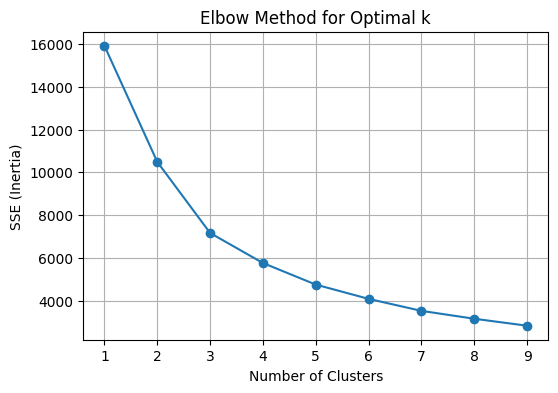

In [52]:
# elbow method for identifying 'k'
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(pca_df[["PC1", "PC2"]])
    sse.append(km.inertia_)

plt.figure(figsize = (6, 4))
plt.plot(range(1, 10), sse, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [53]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

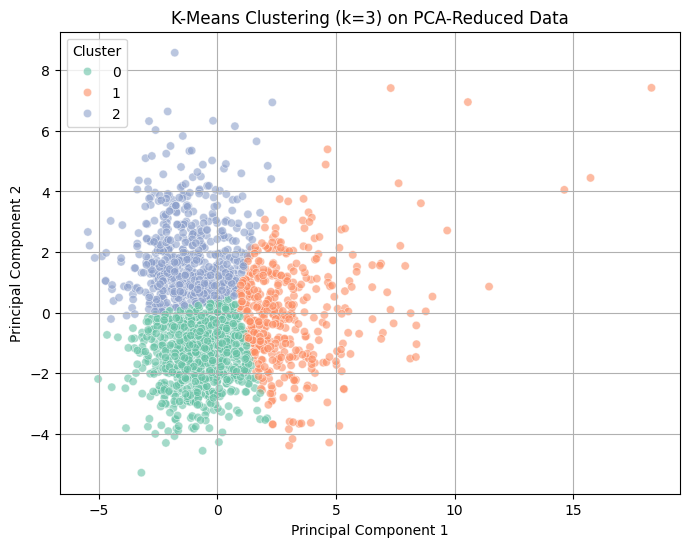

In [54]:
# Plot
plt.figure(figsize = (8, 6))
sns.scatterplot(
    x = 'PC1', y = 'PC2',
    data = pca_df,
    hue = 'Cluster',
    palette = 'Set2',
    alpha = 0.6
)
plt.title('K-Means Clustering (k=3) on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title = 'Cluster')
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.357


The Silhouette Score measures how similar a point is to its own cluster vs. other clusters.

Ranges from -1 to 1.

Closer to 1 = well-clustered.

Near 0 = overlapping clusters.

Negative = misclassified points.

Our score is below 0.5, which means the structure isn't super distinct and there's likely some overlap or ambiguous boundaries between the clusters.

# Supervised/Predictive Model

## SVM Regression on Full Feature Set (No PCA)

CV R² (no PCA): 0.2929 ± 0.0301
Test RMSE: 0.8617
Test MAE:  0.6679
Test R²:   0.3249

Shapiro-Wilk (No PCA): W = 0.9949, p = 0.0811
Likely Normal


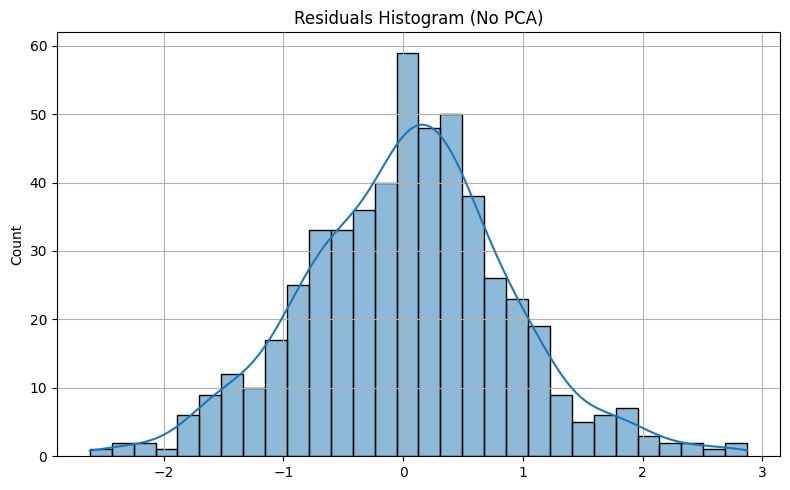

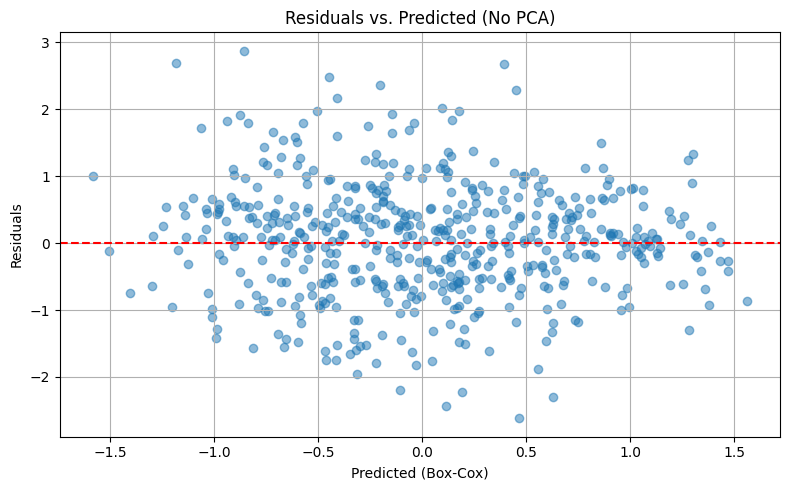

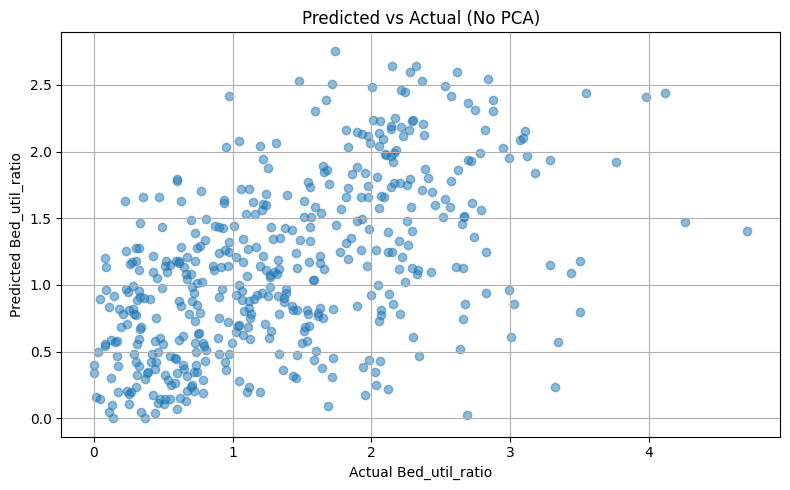


Final RMSE (Original Scale, No PCA): 0.8075
Dropped 68 rows with NaNs from evaluation.


Final RMSE (Original Scale, No PCA): 0.8075


In [56]:
"""
This cell fits a second Support Vector Regression (SVR) model
using the full set of scaled input features (without PCA-based dimensionality reduction).

Purpose:
- To serve as a benchmark and comparison against the SVM model trained on PCA-reduced features
- To assess whether dimensionality reduction via PCA improves, worsens,
or has minimal effect on prediction accuracy

Inputs:
- X_train_scaled, X_test_scaled: Scaled full feature matrices (23 original features,
no dimensionality reduction)
- y_train_bc, y_test_bc: Target variable (Bed_util_ratio), transformed using Box-Cox
to improve normality and stabilize variance

This model:
- Trains an SVR model using the full input space (no PCA)
- Uses 5-fold cross-validation to evaluate training performance (R²)
- Predicts on the Box-Cox transformed test set
- Computes evaluation metrics: RMSE, MAE, and R² on Box-Cox scale
- Performs residual diagnostics:
    - Shapiro-Wilk normality test
    - Histogram and residual scatter plot
- Applies inverse Box-Cox transformation to return predictions to their original scale
- Computes final RMSE in original units and visualizes predicted vs. actual target values
- Handles NaNs resulting from inverse transformation for clean metric reporting

Note:
This section allows side-by-side performance comparison with the PCA-based SVM pipeline
to assess the impact of dimensionality reduction.
"""

# --- SVM Without PCA (on full scaled features) ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import inv_boxcox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM
svm_raw = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv_raw = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_raw = cross_val_score(svm_raw, X_train_scaled, y_train_bc, cv=cv_raw, scoring='r2')

svm_raw.fit(X_train_scaled, y_train_bc)
y_pred_raw_bc = svm_raw.predict(X_test_scaled)

# Evaluate
rmse_raw = np.sqrt(mean_squared_error(y_test_bc, y_pred_raw_bc))
mae_raw = mean_absolute_error(y_test_bc, y_pred_raw_bc)
r2_raw = r2_score(y_test_bc, y_pred_raw_bc)
print(f"CV R² (no PCA): {cv_scores_raw.mean():.4f} ± {cv_scores_raw.std():.4f}")
print(f"Test RMSE: {rmse_raw:.4f}")
print(f"Test MAE:  {mae_raw:.4f}")
print(f"Test R²:   {r2_raw:.4f}")

# Residuals Diagnostics
residuals_raw = y_test_bc - y_pred_raw_bc
stat_raw, p_raw = shapiro(residuals_raw)
print(f"\nShapiro-Wilk (No PCA): W = {stat_raw:.4f}, p = {p_raw:.4f}")
print("Likely Normal" if p_raw > 0.05 else "Not Normal\n")

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals_raw, kde=True, bins=30)
plt.title("Residuals Histogram (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_raw_bc, residuals_raw, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (No PCA)")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform for Interpretation
y_pred_raw_orig = inv_boxcox(y_pred_raw_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred_raw_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure both y_test_orig and y_pred_raw_orig are free of NaNs
valid_mask_raw = ~np.isnan(y_pred_raw_orig) & ~np.isnan(y_test_orig)
rmse_raw_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask_raw], y_pred_raw_orig[valid_mask_raw]))

print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")
print(f"Dropped {(~valid_mask_raw).sum()} rows with NaNs from evaluation.\n")

print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")


In [57]:
print("NaNs in y_pred_raw_orig:", np.isnan(y_pred_raw_orig).sum())


NaNs in y_pred_raw_orig: 5


## SVM Regression on PCA set

CV R² (w/PCA): 0.2989 ± 0.0262
Test RMSE: 0.8684
Test MAE:  0.6691
Test R²:   0.3143

Shapiro-Wilk (w/PCA): W = 0.9933, p = 0.0195
Not Normal



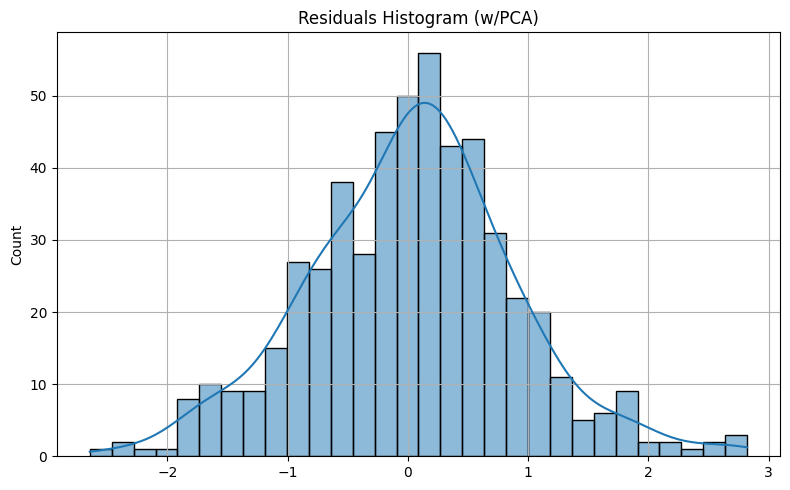

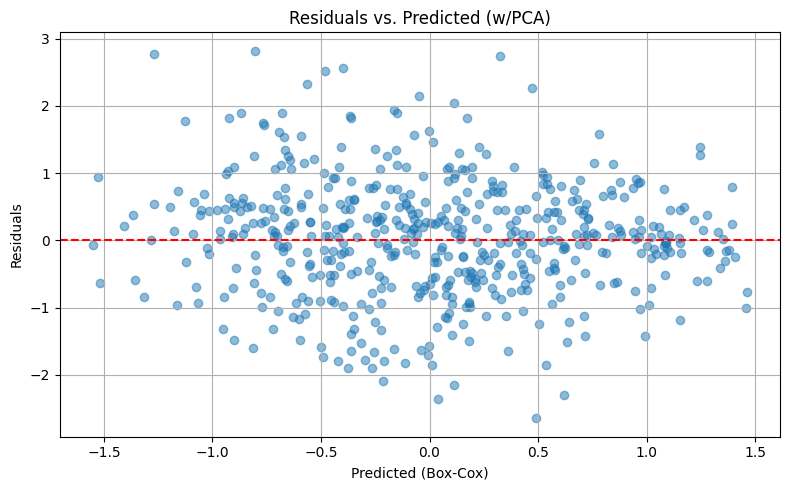

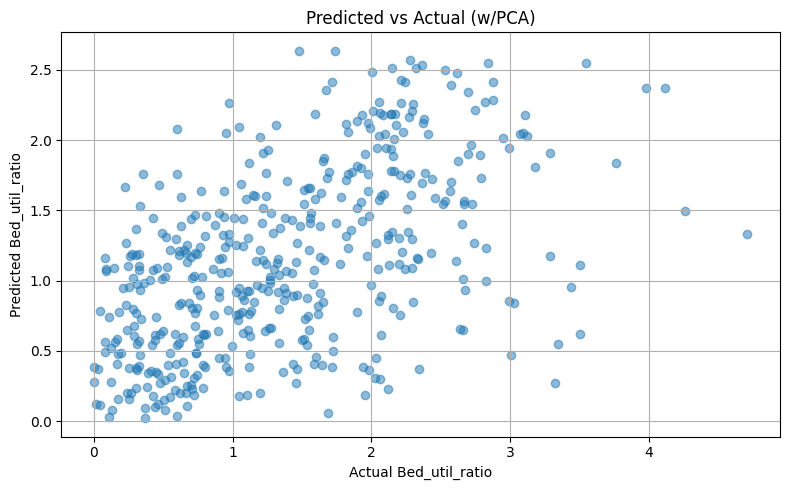


Final RMSE (Original Scale, with PCA): 0.8051
Dropped 71 rows with NaNs from evaluation.


Final RMSE (Original Scale, with PCA): 0.8051


In [58]:
"""
This cell fits a second Support Vector Regression (SVR) model
using the reduced set of scaled input features after PCA dimensionality reduction.

Purpose:
- To serve as a benchmark and comparison against the SVM model trained on PCA-reduced features
- To assess whether dimensionality reduction via PCA improves, worsens,
or has minimal effect on prediction accuracy

Inputs:
- X_train_pca, X_test_pca: Scaled reduced feature matrices (16 features)
- y_train_bc, y_test_bc: Target variable (Bed_util_ratio), transformed using Box-Cox
to improve normality and stabilize variance

This model:
- Trains an SVR model using the PCA-reduced input.
- Uses 5-fold cross-validation to evaluate training performance (R²)
- Predicts on the Box-Cox transformed test set
- Computes evaluation metrics: RMSE, MAE, and R² on Box-Cox scale
- Performs residual diagnostics:
    - Shapiro-Wilk normality test
    - Histogram and residual scatter plot
- Applies inverse Box-Cox transformation to return predictions to their original scale
- Computes final RMSE in original units and visualizes predicted vs. actual target values
- Handles NaNs resulting from inverse transformation for clean metric reporting

Note:
This section allows side-by-side performance comparison with the full set SVM
pipeline to assess the impact of dimensionality reduction.
"""

# --- SVM With PCA ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import inv_boxcox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM
svm_raw = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv_raw = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_raw = cross_val_score(svm_raw, X_train_pca, y_train_bc, cv=cv_raw, scoring='r2')

svm_raw.fit(X_train_pca, y_train_bc)
y_pred_raw_bc = svm_raw.predict(X_test_pca)

# Evaluate
rmse_raw = np.sqrt(mean_squared_error(y_test_bc, y_pred_raw_bc))
mae_raw = mean_absolute_error(y_test_bc, y_pred_raw_bc)
r2_raw = r2_score(y_test_bc, y_pred_raw_bc)
print(f"CV R² (w/PCA): {cv_scores_raw.mean():.4f} ± {cv_scores_raw.std():.4f}")
print(f"Test RMSE: {rmse_raw:.4f}")
print(f"Test MAE:  {mae_raw:.4f}")
print(f"Test R²:   {r2_raw:.4f}")

# Residuals Diagnostics
residuals_raw = y_test_bc - y_pred_raw_bc
stat_raw, p_raw = shapiro(residuals_raw)
print(f"\nShapiro-Wilk (w/PCA): W = {stat_raw:.4f}, p = {p_raw:.4f}")
print("Likely Normal" if p_raw > 0.05 else "Not Normal\n")

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals_raw, kde=True, bins=30)
plt.title("Residuals Histogram (w/PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_raw_bc, residuals_raw, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (w/PCA)")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform for Interpretation
y_pred_raw_orig = inv_boxcox(y_pred_raw_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred_raw_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (w/PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure both y_test_orig and y_pred_raw_orig are free of NaNs
valid_mask_raw = ~np.isnan(y_pred_raw_orig) & ~np.isnan(y_test_orig)
rmse_raw_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask_raw], y_pred_raw_orig[valid_mask_raw]))

print(f"\nFinal RMSE (Original Scale, with PCA): {rmse_raw_orig:.4f}")
print(f"Dropped {(~valid_mask_raw).sum()} rows with NaNs from evaluation.\n")

print(f"\nFinal RMSE (Original Scale, with PCA): {rmse_raw_orig:.4f}")


In [59]:
print("NaNs in y_pred_raw_orig:", np.isnan(y_pred_raw_orig).sum())


NaNs in y_pred_raw_orig: 10
